## Final Model for sby_need

Predict sby_need with predicted calls with RandomForest

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import QuantileRegressor

In [5]:
import sys
print(sys.executable)

/Users/kata/opt/anaconda3/bin/python


In [6]:
# load data
# feature engineering
df = pd.read_csv('/Users/kata/Desktop/GitHub/standby_duty_forecasting/sickness_table.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'])
df['year']= df['date'].dt.year
df['month']= df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['week'] = df['date'].dt.isocalendar().week
df['day_of_month'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
# change type to not get error
df['week'] = df['week'].astype(np.int64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152 entries, 0 to 1151
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1152 non-null   datetime64[ns]
 1   n_sick        1152 non-null   int64         
 2   calls         1152 non-null   float64       
 3   n_duty        1152 non-null   int64         
 4   n_sby         1152 non-null   int64         
 5   sby_need      1152 non-null   float64       
 6   dafted        1152 non-null   float64       
 7   year          1152 non-null   int64         
 8   month         1152 non-null   int64         
 9   day_of_week   1152 non-null   int64         
 10  week          1152 non-null   int64         
 11  day_of_month  1152 non-null   int64         
 12  day_of_year   1152 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(9)
memory usage: 126.0 KB


In [7]:
# predict calls with RF
# define X and y data
X = df[['year', 'month', 'day_of_week',
       'week', 'n_duty', 'n_sby', 'day_of_month', 'day_of_year']]
y = df.calls

In [8]:
# train test split
def train_test_split(data, n_test):
	return data[:n_test], data[n_test:]


x_train, x_test = train_test_split(X, 922)
y_train, y_test = train_test_split(y, 922)

In [9]:
# train first model
# no tuned parameters
model = RandomForestRegressor(n_estimators=1000, random_state=6)
model.fit(x_train, y_train)
pred = model.predict(x_test)

In [10]:
# calculte RMSE and MSE
print('RMSE:', np.sqrt(mean_squared_error(y_test, pred)))
print('MSE:', mean_squared_error(y_test, pred))

RMSE: 1235.3986317853141
MSE: 1526209.779417026


In [11]:
# are alle variables necessary?
# Saving feature names for later use
feature_list = list(X.columns)
pprint(feature_list)

['year',
 'month',
 'day_of_week',
 'week',
 'n_duty',
 'n_sby',
 'day_of_month',
 'day_of_year']


In [12]:
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: day_of_year          Importance: 0.37
Variable: day_of_month         Importance: 0.24
Variable: day_of_week          Importance: 0.14
Variable: year                 Importance: 0.07
Variable: week                 Importance: 0.07
Variable: n_duty               Importance: 0.07
Variable: month                Importance: 0.04
Variable: n_sby                Importance: 0.0


Leave sby_need out:

In [13]:
# predict calls with RF
# define X and y data
X_no_sby = df[['year', 'month', 'day_of_week',
       'week', 'n_duty', 'day_of_month', 'day_of_year']]
y_no_sby = df.calls

x_train_no_sby, x_test_no_sby = train_test_split(X, 922)
y_train_no_sby, y_test_no_sby = train_test_split(y, 922)

In [14]:
# remove n-sby
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('week'), feature_list.index('year'), feature_list.index('day_of_month'), feature_list.index('n_duty'), feature_list.index('month'), feature_list.index('day_of_year')]
train_important = x_train_no_sby[['week', 'year', 'day_of_month', 'n_duty', 'month', 'day_of_year']]
test_important = x_test_no_sby[['week', 'year', 'day_of_month', 'n_duty', 'month', 'day_of_year']]
# Train the random forest
rf_most_important.fit(train_important, y_train_no_sby)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
# Display the performance metrics
# calculate RMSE and MSE
print('RMSE:', np.sqrt(mean_squared_error(y_test_no_sby, predictions)))
print('MSE:', mean_squared_error(y_test_no_sby, predictions))

RMSE: 1267.7218245329896
MSE: 1607118.624397252


Somehow performence decreased --> we are keeping n_sby

#### Prepare for visualization

In [15]:
# visualization
# Dates of the actual training values
months = X['month']
days = X['day_of_month']
years = X['year']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]


# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': y})

In [16]:
# Dates of the predictions
months = x_test['month']
days = x_test['day_of_month']
years = x_test['year']

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': pred})

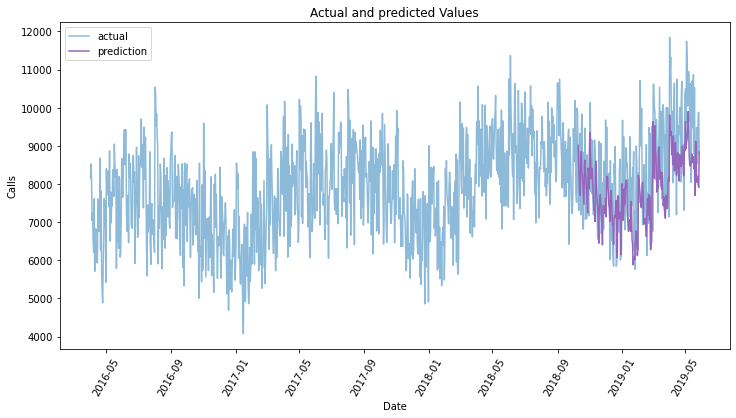

In [17]:
# plot prediction and actual values
plt.figure(figsize=(12,6))
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5, color='tab:blue')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], label = 'prediction', color='tab:purple')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Calls'); plt.title('Actual and predicted Values');

### Hyperparameter Tuning

In [18]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 6,
 'verbose': 0,
 'warm_start': False}


In [19]:
# grid search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [20]:
# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

In [21]:
# pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [22]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# model = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
#model_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [25]:
# view best parameters
#model_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

Best parameters:
{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [27]:
# Evaluate Random Search
# To determine if random search yielded a better model, we compare the base model with the best random search model.
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mse = mean_squared_error(test_labels, predictions)
    rmse = np.sqrt(mse)
    print('Model Performance')
    print('Mean Squared Error: {:0.2f}'.format(mse))
    print('Root Mean Squared Error: {:0.2f}'.format(rmse))
    
    return rmse, mse


In [32]:
base_model = RandomForestRegressor(n_estimators = 1000, random_state = 6)
base_model.fit(x_train, y_train)
evaluate(base_model, x_test, y_test)

Model Performance
Mean Squared Error: 1526209.78
Root Mean Squared Error: 1235.40


(1235.3986317853141, 1526209.779417026)

In [33]:
#best_random = model_random.best_estimator_
#evaluate(best_random, x_test, y_test)

Model Performance
Mean Squared Error: 1437657.10
Root Mean Squared Error: 1199.02


(1199.0233944795923, 1437657.1005093642)

Performance got better with the new parameters, now we get even more specific with grid search

In [37]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [0, 10, 20],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [3, 5, 7],
    'n_estimators': [1800, 2000, 2200]
}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [38]:
# Fit the grid search to the data
#grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/Users/kata/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
81 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kata/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kata/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 476, in fit
    trees = Parallel(
  File "/Users/kata/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 1800}

In [39]:
#grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 1800}

best params:
<br>
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 1800}

In [41]:
best_grid = grid_search.best_estimator_
evaluate(best_grid, x_test, y_test)

Model Performance
Mean Squared Error: 1420469.79
Root Mean Squared Error: 1191.83


(1191.8346317371775, 1420469.7894080933)

--> slightly better

### Make final prediction with new parameters

In [47]:
rf = RandomForestRegressor(bootstrap=True, max_depth=10, max_features='sqrt', 
min_samples_leaf=1, min_samples_split=7, n_estimators=1800, random_state=6)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)
evaluate(rf, x_test, y_test)


Model Performance
Mean Squared Error: 1418403.44
Root Mean Squared Error: 1190.97


(1190.9674372471106, 1418403.4365829504)

In [44]:
# prepare for visualization
# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': pred})

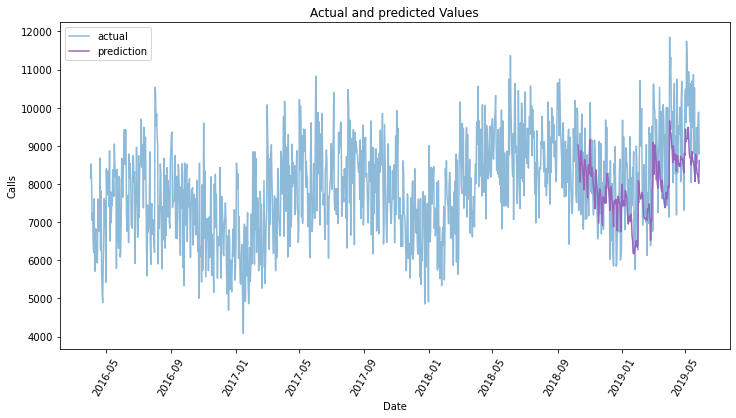

In [48]:
# plot new predictions
# plot prediction and actual values
plt.figure(figsize=(12,6))
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual', alpha=0.5, color='tab:blue')
# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], label = 'prediction', color='tab:purple')
plt.xticks(rotation = '60'); 
plt.legend()
# Graph labels
plt.xlabel('Date'); plt.ylabel('Calls'); plt.title('Actual and predicted Values');

## Predict sby_need with predicted calls